In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Defining some constants:

In [2]:
beta = 1.
U = 0.1
t = 1.

In [3]:
#definition of FourierTransforms
def matsubara_fft(G_tau):
    N = G_tau.shape[0]
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft(G_tau*np.exp(1j*np.pi*k/N))
#numpy orders frequencies differently so one has to convert frequencies
def matsubara_freq(N):
    return np.pi/beta *(-2*(np.fft.fftfreq(N))*N+1)
def matsubara_ifft(G_omega):
    N = G_omega.shape[0]
    k = np.arange(N,dtype='float')
    return N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega)
#following has to be improved:
def matsubara_ifft_trick(G_omega):
    N = G_omega.shape[0]
    freq = matsubara_freq(N)
    k = np.arange(N,dtype='float')
    return -1/2+N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega-1./(1j*freq) )


In [4]:
N=500
tau = linspace(0,beta*(1.-1./N),N)
dtau = beta/N
a=10.
freq = matsubara_freq(N)

Self-Energy in second order perturbation theory:
$$ Σ(iω) = -U^2 \frac{1}{\beta^2}\sum_{iν, iγ} G_0(iν) G_0(-ω + ν + γ) G_0(q)\\
= -U^2 \int_0^β dτ G_0(τ)^2 G_0(-τ) e^{iω τ}$$

In [5]:
def self_energy(G0_omega):
    G0_tau = matsubara_ifft(G0_omega)
    return U**2*dtau*np.sum(G0_tau**2*np.roll(G0_tau[::-1],1)*np.exp(1j *freq[:,np.newaxis]*tau),axis=1)

$$G_{loc} = \frac{1}{N_k} \sum_k\frac{1}{iω_n -ε_k - Σ_{imp}(iω)}$$

In [6]:
#dispersion realtion as in Fabian's worksheet
Nk = N
k = linspace(-np.pi,np.pi, Nk)
epsilon_k = -2.*t*np.cos(k)
def Gloc_omega(self_energy_omega):
    return 1/Nk*np.sum(1/(1j*freq-epsilon_k[:, np.newaxis]-self_energy_omega),axis=0)

In [7]:
tmp = []
it = []
def DMFT_loop(G0_initial_omega, iterations):
    G0_omega= G0_initial_omega
    for i in range(iterations):
        self_e = self_energy(G0_omega)
        Gloc = Gloc_omega(self_e)
        G0_omega = 1/(1/Gloc+self_e+U/2.)
        if i%iterations//10 ==0:
            print(100*i/iterations)
            tmp.append(Gloc)
    return tmp

In [8]:
def DMFT_loop2(G0_initial_omega):
    G0_omega= G0_initial_omega
    self_e = self_energy(G0_omega)
    Gloc = Gloc_omega(self_e)
    G0_omega = 1/(1/Gloc+self_e+U/2.)
    return G0_omega

In [9]:
a = 1
G0_initial_omega = 1. / ( 1j*freq + a )

In [10]:
DMFT_solutions = DMFT_loop(G0_initial_omega,100)
#DMFT_solution_tau = matsubara_ifft_trick(DMFT_solution)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [11]:
tmp = np.array(DMFT_solutions)

In [12]:
from ipywidgets import interact

In [13]:
def plot(i=0):
    DMFT_solution = tmp[i]
    fig, ax = plt.subplots(ncols=2,figsize=(12,5))
    ax[0].set_title("Real part")
    #ax[0].plot(freq, G0_initial_omega.real,"+",label="G0_initial")
    ax[0].plot(freq, DMFT_solution.real,"+",label="Gloc DMFT")
    ax[0].set_xlabel("$\omega$")

    ax[1].set_title("imag part")
    #ax[1].plot(freq, G0_initial_omega.imag,"+",label="G0_initial")
    ax[1].plot(freq, DMFT_solution.imag,"+",label="Gloc DMFT")
    ax[1].set_xlabel("$\omega$")

    ax[0].legend()
    ax[1].legend()


<function __main__.plot>

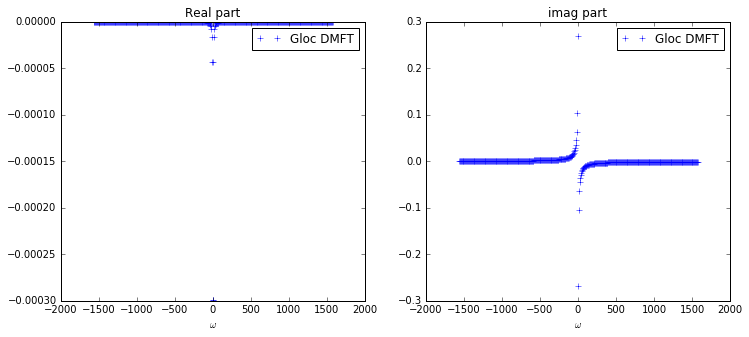

In [14]:
interact(plot, i=(0,10,1))

NameError: name 'DMFT_solution' is not defined

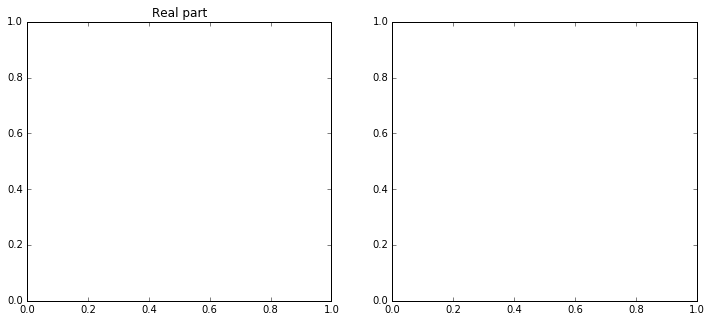

In [15]:
fig, ax = plt.subplots(ncols=2,figsize=(12,5))
ax[0].set_title("Real part")
#ax[0].plot(freq, G0_initial_omega.real,"+",label="G0_initial")
ax[0].plot(freq, DMFT_solution.real,"+",label="Gloc DMFT")
ax[0].set_xlabel("$\omega$")

ax[1].set_title("imag part")
#ax[1].plot(freq, G0_initial_omega.imag,"+",label="G0_initial")
ax[1].plot(freq, DMFT_solution.imag,"+",label="Gloc DMFT")
ax[1].set_xlabel("$\omega$")

ax[0].legend()
ax[1].legend()


In [ ]:
plot(tau,DMFT_solution_tau.real)
#plot(tau,DMFT_solution_tau.imag)